In [1]:
%run "..\..\Startup_py3.py"
sys.path.append(r"..\..\..\..\Documents")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast

37712


In [2]:
import cv2

In [3]:
data_folder = r'\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors'

folders, fovs = ia.io_tools.data.get_folders(data_folder)


Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 11
- Number of field of views: 168


In [4]:
correction_folder = r'\\10.245.74.158\Chromatin_NAS_0\Corrections\20210621-Corrections_lumencor_from_60_to_50'

segmentation_save_folder = os.path.join(data_folder, 'Segmentation')
if not os.path.exists(segmentation_save_folder):
    os.makedirs(segmentation_save_folder)
from cellpose import models

from ImageAnalysis3.segmentation_tools.cell import Align_Segmentation
reload(ia.segmentation_tools.cell)

# transpose with microscope
microscope_file = r'\\mendel\pu_documents\Merfish_analysis\Merfish_Analysis_Scripts\merlin_parameters\microscope\storm6_microscope.json'
microscope_params = Align_Segmentation._read_microscope_json(microscope_file)
microscope_params

{'flip_horizontal': False,
 'flip_vertical': True,
 'transpose': True,
 'microns_per_pixel': 0.108}

In [5]:

for _fov_id, _fov_name in enumerate(fovs):
    
    seg_save_file = os.path.join(segmentation_save_folder, f'segmentation_label_{_fov_id}.npy')
    if os.path.exists(seg_save_file):
        continue

    dapi_image_file = os.path.join(folders[0], _fov_name)
    print(dapi_image_file)
    # load reference DAPI
    _ref_cls = ia.classes.preprocess.DaxProcesser(dapi_image_file, 
                                                 CorrectionFolder=correction_folder, DriftChannel=488, DapiChannel=405)
    _ref_cls._load_image(sel_channels=[561,405])
    _ref_cls._corr_illumination()

    # cellpose
    print(f"- apply microscope corrections")
    test_dapi_im = Align_Segmentation._correct_image3D_by_microscope_param(_ref_cls.im_405[0::4], microscope_params)
    test_polyt_im = Align_Segmentation._correct_image3D_by_microscope_param(_ref_cls.im_561[0::4], microscope_params)
    
    print(f"- run Cellpose segmentation", end=' ')
    _cellpose_start = time.time()
    test_dapi_im = np.array([cv2.resize(_ly, (1024,1024) ) for _ly in test_dapi_im])
    test_polyt_im = np.array([cv2.resize(_ly, (1024,1024) ) for _ly in test_polyt_im])

    seg_model = models.CellposeModel(gpu=True, model_type='TN2')

    labels3d, _, _ = seg_model.eval(np.stack([test_polyt_im, test_dapi_im], axis=3), 
                                    batch_size=20, anisotropy=1000/108/2,
                                    cellprob_threshold=0, 
                                    channels=[1,2], diameter=30, min_size=100,
                                    do_3D=True,
                                    )

    print(f"in {time.time()-_cellpose_start:.3f}s.")
    
    
    # resize segmentation label back
    labels3d = np.array([cv2.resize(_ly, _ref_cls.im_405.shape[1:], 
                                    interpolation=cv2.INTER_NEAREST_EXACT) 
                         for _ly in labels3d])

    
    print(labels3d.shape, _fov_id)
    # save this segmentation mask
    print(f"- save to file: {seg_save_file}")
    np.save(seg_save_file.split('.npy')[0], labels3d, )

## Watershed

In [9]:
sys.path.append(r"..\..\MERlin")

import merlin
from merlin.util import watershed
from scipy import ndimage
from skimage import morphology
from skimage import segmentation

watershed_folder = os.path.join(segmentation_save_folder, 'watershed')
if not os.path.exists(watershed_folder):
    print(watershed_folder)
    os.makedirs(watershed_folder)

\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Segmentation\watershed


In [33]:
for _fov_id, _fov_name in enumerate(fovs):
    
    _save_id = _fov_id
    seg_save_file = os.path.join(segmentation_save_folder, f'segmentation_label_{_save_id}.npy')
    watershed_save_file = os.path.join(watershed_folder, f'segmentation_label_{_save_id}.npy')
    if os.path.exists(watershed_save_file):
        continue
    
    print(f"- load seg file: {seg_save_file}")
    corr_labels3d = np.load(seg_save_file)
    
    dapi_image_file = os.path.join(folders[0], _fov_name)
    polyt_image_file = os.path.join(folders[-1], _fov_name)
    print(dapi_image_file, polyt_image_file)
    # load reference DAPI
    _ref_cls = ia.classes.preprocess.DaxProcesser(dapi_image_file, 
                                                 CorrectionFolder=correction_folder, DriftChannel=488, DapiChannel=405)
    _ref_cls._load_image(sel_channels=[561,405])
    _ref_cls._corr_illumination()

    polyt_im = Align_Segmentation._correct_image3D_by_microscope_param(_ref_cls.im_561[::4], microscope_params)
    # Prepare watershed
    waterIm, waterMask = watershed.prepare_watershed_images(polyt_im, 1.5)
    waterMask[corr_labels3d > 0] = True
    # watershed
    new_labels = segmentation.watershed(
                    waterIm, corr_labels3d, mask=waterMask,
                    connectivity=np.ones((3, 3, 3)), watershed_line=True)
    new_labels = ndimage.grey_dilation(new_labels, structure=morphology.ball(1))
    # save
    # save this segmentation mask
    print(f"- save to file: {watershed_save_file}")
    np.save(watershed_save_file.split('.npy')[0], new_labels, )
    

- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_0.npy
\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_000.dax \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H10M11\Conv_zscan_000.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_000.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['561', '405'] in 6.062s.
- Start illumination correction for channels:['561', '405'].
-- loading illumination correction profile from file:
	 561 illumination_correction_561_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 561 in 8.427s.
-- corrected illumination for channel 405 in 9.156s.
- Finished illumination correction in 17.813s.
- save to file: \\10.245.74.158\Chromatin_

- Start illumination correction for channels:['561', '405'].
-- loading illumination correction profile from file:
	 561 illumination_correction_561_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 561 in 10.250s.
-- corrected illumination for channel 405 in 12.484s.
- Finished illumination correction in 24.250s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Segmentation\watershed\segmentation_label_8.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_9.npy
\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_009.dax \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H10M11\Conv_zscan_009.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_009.dax
-- all used channels: ['750', '647', '561', '488', '405']


\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_016.dax \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H10M11\Conv_zscan_016.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_016.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['561', '405'] in 8.735s.
- Start illumination correction for channels:['561', '405'].
-- loading illumination correction profile from file:
	 561 illumination_correction_561_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 561 in 8.594s.
-- corrected illumination for channel 405 in 8.453s.
- Finished illumination correction in 17.391s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Segmentation\watershed\segmentation_label_16.npy
- load seg file: \\10.245.74.158

-- corrected illumination for channel 561 in 8.172s.
-- corrected illumination for channel 405 in 8.265s.
- Finished illumination correction in 16.687s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Segmentation\watershed\segmentation_label_23.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_24.npy
\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_024.dax \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H10M11\Conv_zscan_024.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_024.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['561', '405'] in 6.781s.
- Start illumination correction for channels:['561', '405'].
-- loading illumination correction profile from file:
	 

- Loaded images for channels:['561', '405'] in 6.563s.
- Start illumination correction for channels:['561', '405'].
-- loading illumination correction profile from file:
	 561 illumination_correction_561_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 561 in 8.151s.
-- corrected illumination for channel 405 in 8.172s.
- Finished illumination correction in 16.531s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Segmentation\watershed\segmentation_label_31.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_32.npy
\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_032.dax \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H10M11\Conv_zscan_032.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_032.dax
-- 

- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_39.npy
\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_039.dax \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H10M11\Conv_zscan_039.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_039.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['561', '405'] in 8.202s.
- Start illumination correction for channels:['561', '405'].
-- loading illumination correction profile from file:
	 561 illumination_correction_561_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 561 in 8.828s.
-- corrected illumination for channel 405 in 8.734s.
- Finished illumination correction in 17.797s.
- save to file: \\10.245.74.158\Chromatin

- Loaded images for channels:['561', '405'] in 8.562s.
- Start illumination correction for channels:['561', '405'].
-- loading illumination correction profile from file:
	 561 illumination_correction_561_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 561 in 8.187s.
-- corrected illumination for channel 405 in 8.438s.
- Finished illumination correction in 17.031s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Segmentation\watershed\segmentation_label_46.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_47.npy
\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_047.dax \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H10M11\Conv_zscan_047.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_047.dax
-- 

- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_54.npy
\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_054.dax \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H10M11\Conv_zscan_054.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_054.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['561', '405'] in 7.219s.
- Start illumination correction for channels:['561', '405'].
-- loading illumination correction profile from file:
	 561 illumination_correction_561_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 561 in 8.188s.
-- corrected illumination for channel 405 in 8.313s.
- Finished illumination correction in 16.797s.
- save to file: \\10.245.74.158\Chromatin

- Loaded images for channels:['561', '405'] in 12.750s.
- Start illumination correction for channels:['561', '405'].
-- loading illumination correction profile from file:
	 561 illumination_correction_561_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 561 in 8.011s.
-- corrected illumination for channel 405 in 8.969s.
- Finished illumination correction in 17.525s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Segmentation\watershed\segmentation_label_61.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_62.npy
\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_062.dax \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H10M11\Conv_zscan_062.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_062.dax
--

- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_69.npy
\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_069.dax \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H10M11\Conv_zscan_069.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_069.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['561', '405'] in 7.672s.
- Start illumination correction for channels:['561', '405'].
-- loading illumination correction profile from file:
	 561 illumination_correction_561_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 561 in 8.125s.
-- corrected illumination for channel 405 in 8.688s.
- Finished illumination correction in 17.141s.
- save to file: \\10.245.74.158\Chromatin

- Loaded images for channels:['561', '405'] in 6.922s.
- Start illumination correction for channels:['561', '405'].
-- loading illumination correction profile from file:
	 561 illumination_correction_561_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 561 in 8.172s.
-- corrected illumination for channel 405 in 8.438s.
- Finished illumination correction in 16.938s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Segmentation\watershed\segmentation_label_76.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_77.npy
\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_077.dax \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H10M11\Conv_zscan_077.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_077.dax
-- 

- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_84.npy
\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_084.dax \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H10M11\Conv_zscan_084.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_084.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['561', '405'] in 6.477s.
- Start illumination correction for channels:['561', '405'].
-- loading illumination correction profile from file:
	 561 illumination_correction_561_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 561 in 8.251s.
-- corrected illumination for channel 405 in 8.358s.
- Finished illumination correction in 16.843s.
- save to file: \\10.245.74.158\Chromatin

- Loaded images for channels:['561', '405'] in 7.312s.
- Start illumination correction for channels:['561', '405'].
-- loading illumination correction profile from file:
	 561 illumination_correction_561_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 561 in 9.578s.
-- corrected illumination for channel 405 in 10.141s.
- Finished illumination correction in 19.969s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Segmentation\watershed\segmentation_label_91.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_92.npy
\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_092.dax \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H10M11\Conv_zscan_092.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_092.dax
--

- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_99.npy
\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_099.dax \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H10M11\Conv_zscan_099.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_099.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['561', '405'] in 6.750s.
- Start illumination correction for channels:['561', '405'].
-- loading illumination correction profile from file:
	 561 illumination_correction_561_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 561 in 9.484s.
-- corrected illumination for channel 405 in 9.234s.
- Finished illumination correction in 18.844s.
- save to file: \\10.245.74.158\Chromatin

- Loaded images for channels:['561', '405'] in 6.047s.
- Start illumination correction for channels:['561', '405'].
-- loading illumination correction profile from file:
	 561 illumination_correction_561_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 561 in 8.453s.
-- corrected illumination for channel 405 in 8.359s.
- Finished illumination correction in 17.219s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Segmentation\watershed\segmentation_label_106.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_107.npy
\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_107.dax \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H10M11\Conv_zscan_107.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_107.dax
-

- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_114.npy
\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_114.dax \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H10M11\Conv_zscan_114.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_114.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['561', '405'] in 6.547s.
- Start illumination correction for channels:['561', '405'].
-- loading illumination correction profile from file:
	 561 illumination_correction_561_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 561 in 8.422s.
-- corrected illumination for channel 405 in 8.437s.
- Finished illumination correction in 17.000s.
- save to file: \\10.245.74.158\Chromati

- Loaded images for channels:['561', '405'] in 6.568s.
- Start illumination correction for channels:['561', '405'].
-- loading illumination correction profile from file:
	 561 illumination_correction_561_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 561 in 8.593s.
-- corrected illumination for channel 405 in 8.297s.
- Finished illumination correction in 17.125s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Segmentation\watershed\segmentation_label_121.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_122.npy
\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_122.dax \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H10M11\Conv_zscan_122.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_122.dax
-

- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_129.npy
\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_129.dax \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H10M11\Conv_zscan_129.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_129.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['561', '405'] in 6.000s.
- Start illumination correction for channels:['561', '405'].
-- loading illumination correction profile from file:
	 561 illumination_correction_561_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 561 in 8.401s.
-- corrected illumination for channel 405 in 8.094s.
- Finished illumination correction in 16.703s.
- save to file: \\10.245.74.158\Chromati

- Loaded images for channels:['561', '405'] in 5.719s.
- Start illumination correction for channels:['561', '405'].
-- loading illumination correction profile from file:
	 561 illumination_correction_561_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 561 in 8.233s.
-- corrected illumination for channel 405 in 8.328s.
- Finished illumination correction in 16.797s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Segmentation\watershed\segmentation_label_136.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_137.npy
\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_137.dax \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H10M11\Conv_zscan_137.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_137.dax
-

- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_144.npy
\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_144.dax \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H10M11\Conv_zscan_144.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_144.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['561', '405'] in 6.056s.
- Start illumination correction for channels:['561', '405'].
-- loading illumination correction profile from file:
	 561 illumination_correction_561_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 561 in 8.703s.
-- corrected illumination for channel 405 in 8.812s.
- Finished illumination correction in 17.702s.
- save to file: \\10.245.74.158\Chromati

- Loaded images for channels:['561', '405'] in 6.825s.
- Start illumination correction for channels:['561', '405'].
-- loading illumination correction profile from file:
	 561 illumination_correction_561_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 561 in 8.329s.
-- corrected illumination for channel 405 in 8.250s.
- Finished illumination correction in 16.766s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Segmentation\watershed\segmentation_label_151.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_152.npy
\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_152.dax \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H10M11\Conv_zscan_152.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_152.dax
-

- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_159.npy
\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_159.dax \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H10M11\Conv_zscan_159.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_159.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['561', '405'] in 5.863s.
- Start illumination correction for channels:['561', '405'].
-- loading illumination correction profile from file:
	 561 illumination_correction_561_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 561 in 8.406s.
-- corrected illumination for channel 405 in 8.375s.
- Finished illumination correction in 16.969s.
- save to file: \\10.245.74.158\Chromati

- Loaded images for channels:['561', '405'] in 6.703s.
- Start illumination correction for channels:['561', '405'].
-- loading illumination correction profile from file:
	 561 illumination_correction_561_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 561 in 8.266s.
-- corrected illumination for channel 405 in 8.719s.
- Finished illumination correction in 17.203s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Segmentation\watershed\segmentation_label_166.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_167.npy
\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_167.dax \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H10M11\Conv_zscan_167.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_167.dax
-

## Check result

<IPython.core.display.Javascript object>


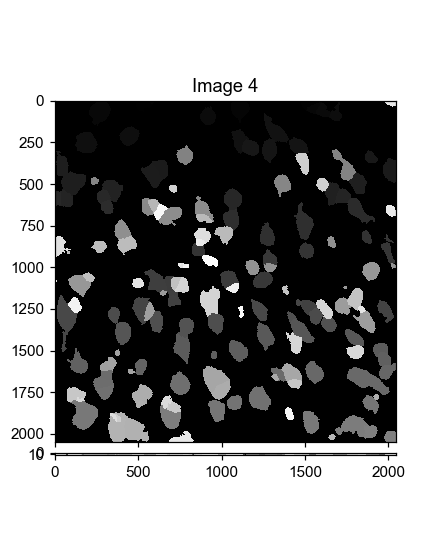

In [34]:
visual_tools.imshow_mark_3d_v2([_ref_cls.im_405[::4], polyt_im, corr_labels3d, new_labels])